# 5: Regime model simulation 

### Import required packages 

In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

T = 240  # z.B. 20 Jahre monatlich
dates = pd.date_range("2005-01-01", periods=T, freq="M")

# -----------------------------
# 1) Makrovariable: Zins
# -----------------------------
zins = (
    0.03
    + 0.01 * np.sin(np.linspace(0, 6 * np.pi, T))   # Zinszyklen
    + rng.normal(0, 0.002, T)                       # Rauschen
)

# -----------------------------
# 2) Latente Regime (Markov)
# -----------------------------
# Übergangsmatrix
P = np.array([
    [0.95, 0.05],   # Regime 0 bleibt meist 0
    [0.07, 0.93],   # Regime 1 bleibt meist 1
])

s = np.zeros(T, dtype=int)
for t in range(1, T):
    s[t] = 0 if rng.random() < P[s[t-1], 0] else 1

# -----------------------------
# 3) Regime-spezifische Parameter
# -----------------------------
mu = np.where(s == 0,  0.35, -0.35)   # Buy vs Rent Regime
sigma = np.where(s == 0, 0.12, 0.20)  # unterschiedliche Unsicherheit
beta_zins = -7.0                      # höhere Zinsen -> Kaufen schlechter

# -----------------------------
# 4) Score erzeugen
# -----------------------------
score = (
    mu
    + beta_zins * (zins - np.mean(zins))
    + rng.normal(0, sigma, T)
)

df_sim = pd.DataFrame({
    "date": dates,
    "score": score,
    "zins": zins,
    "true_regime": s,
}).set_index("date")

C:\Users\49176\AppData\Local\Temp\ipykernel_20760\4093221895.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2005-01-01", periods=T, freq="M")


In [7]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

y = df_sim["score"]
X = sm.add_constant(df_sim[["zins"]])

mod = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    trend="c",
    switching_variance=True
)

res = mod.fit(disp=False)
print(res.summary())


c:\Users\49176\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  score   No. Observations:                  240
Model:               MarkovRegression   Log Likelihood                  58.078
Date:                Wed, 17 Dec 2025   AIC                            -96.156
Time:                        10:45:23   BIC                            -61.350
Sample:                    01-31-2005   HQIC                           -82.132
                         - 12-31-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2774   9652.652   2.87e-05      1.000   -1.89e+04    1.89e+04
x1             0.2774   9652.652   2.87e-05      1.0

In [8]:
probs = res.smoothed_marginal_probabilities

df_sim["p_regime0"] = probs[0]
df_sim["p_regime1"] = probs[1]

# geschätztes Regime
df_sim["regime_hat"] = (df_sim["p_regime1"] > 0.5).astype(int)


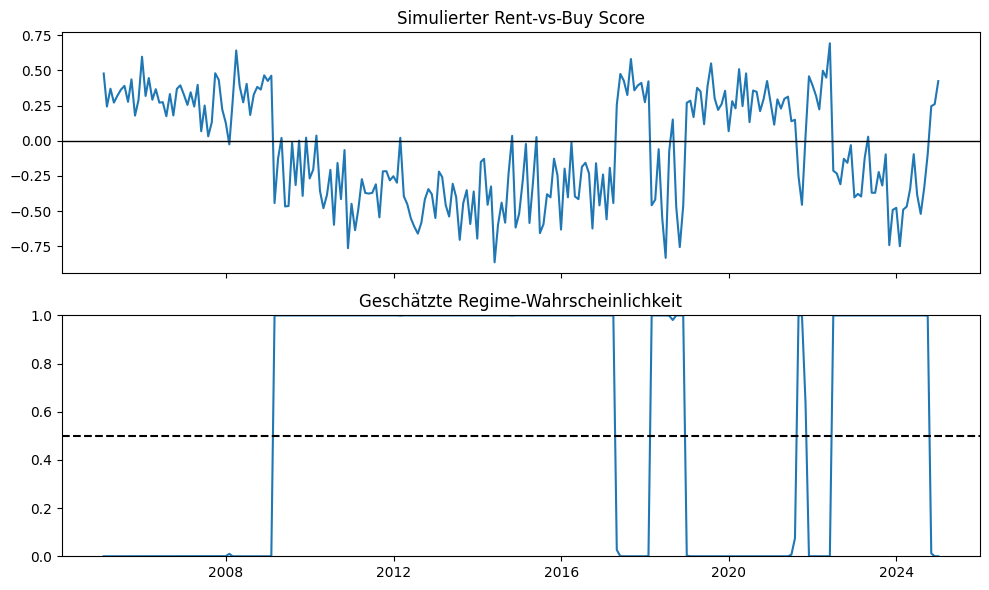

In [9]:
import matplotlib.pyplot as plt

# Score + Regime-Wahrscheinlichkeit
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(df_sim.index, df_sim["score"], label="Score")
ax[0].axhline(0, color="black", linewidth=1)
ax[0].set_title("Simulierter Rent-vs-Buy Score")

ax[1].plot(df_sim.index, df_sim["p_regime1"], label="P(Regime = Rent-friendly)")
ax[1].set_ylim(0, 1)
ax[1].set_title("Geschätzte Regime-Wahrscheinlichkeit")
ax[1].axhline(0.5, color="black", linestyle="--")

plt.tight_layout()
plt.show()


In [10]:
accuracy = (df_sim["regime_hat"] == df_sim["true_regime"]).mean()
print("Regime-Zuordnungsgenauigkeit:", round(accuracy, 3))


Regime-Zuordnungsgenauigkeit: 0.996
